# Семинар. VQ-VAE

В этом семинаре мы рассмотрим архитектуру VQ-VAE для датасета fashion MNIST.

## Импорты и датасет

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [ ]:
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
])

# Load the dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

In [ ]:
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

## Модель

Для того, чтобы реализовать VQ-VAE, нам необходимо сначала сделать слой, отвечающий за codebook.

In [ ]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings=10, embedding_dim=128):
        super(VectorQuantizer, self).__init__()

        # определяем размерность векторов codebook
        self._embedding_dim = embedding_dim
        # определяем их количество
        self._num_embeddings = num_embeddings

        # иницилиализируем нашу codebook как обучаемую матрицу
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        # зададим равномерное распределение при инициализации
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)

    def forward(self, inputs)
        # преобразуем размерность тензора из BCHW -> BWHC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape

        # выпрямим вектор в (-1, размерность векторов codebook)
        flat_input = inputs.view(-1, self._embedding_dim)

        # вычисляем расстояния между векторами codebook и нашим входом
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))

        # смотрим, какой вектор codebook ближайший ко входу
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        # создадим матрицу индексов...
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        # и запишем туда индексы векторов codebook
        encodings.scatter_(1, encoding_indices, 1)

        # квантизуем получившуюся матрицу для обучения матрицы весов
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)

        # эта операция копирует градиенты из input в quantized
        quantized = inputs + (quantized - inputs).detach()
        # преобразуем к BWHC -> BCHW
        quantized = quantized.permute(0, 3, 1, 2).contiguous()

        return quantized

Определим также лосс-функцию для нашего VQ-VAE.

In [ ]:
class QuantizerLoss(nn.Module):
    def __init__(self, commitment_cost):
        super().__init__()
        self.commitment_cost = commitment_cost
        self.mse = nn.MSELoss()

    def forward(self, z, quantized):
        # первое слагаемое заставляет вектора codebook "сближаться" с кодировщиком
        # второе слагаемое заставляет кодировщик подстраиваться под вектора codebook
        return self.mse(quantized, z.detach()) + self.commitment_cost * self.mse(quantized.detach(), z)

In [ ]:
class VQVAELoss(nn.Module):
    def __init__(self, commitment_cost=0.5):
        super().__init__()
        self.recon = nn.MSELoss()
        self.quantizer = QuantizerLoss(commitment_cost)

    def forward(self, x, recon, z, quantized):
        # итоговая лосс-функция состоит из вектора-реконструкции и лосса для codebook
        return self.recon(x, recon) + self.quantizer(z, quantized)

In [ ]:
class VQVAE(nn.Module):
    def __init__(
            self,
            num_embeddings=10,
            embedding_dim=128,
            ):
        super().__init__()

        self.enc = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.LeakyReLU(),
        )

        self.quantizer = VectorQuantizer(num_embeddings, embedding_dim)

        self.dec = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3,  stride=2),
            nn.LeakyReLU(),
            nn.Dropout(p=0.2),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3,  stride=2, output_padding=1),
            nn.LeakyReLU(),
            nn.Sigmoid()
        )


    def encode(self, x):
        return self.enc(x)

    def decode(self, z):
        out = self.dec(z)
        return out

    def forward(self, x):
        z = self.encode(x)
        quantized = self.quantizer(z)
        out = self.decode(quantized)
        return out, z, quantized

In [ ]:
def train_autoencoder(model, dataloader, criterion, optimizer, epochs, device):
    train_loss = []

    for i in range(epochs):
        model.to(device)
        model.train()
        train_epoch_loss = []
        tqdm_iter = tqdm(dataloader)
        for batch in tqdm_iter:
            images, _ = batch
            images = images.to(device)

            optimizer.zero_grad()

            pred = model(images)
            recon, z, quantized = pred
            loss = criterion(images, recon, z, quantized)

            loss.backward()
            optimizer.step()
            tqdm_iter.set_postfix(loss=f'{loss.item():.5f}')
        train_epoch_loss.append(loss.item())
        train_loss.append(np.mean(train_epoch_loss))
        tqdm_iter.set_postfix(loss=f'{train_loss[-1]:.5f}')
    return train_loss

In [ ]:
criterion = VQVAELoss(commitment_cost=0.5)
model = VQVAE(num_embeddings=32)
optimizer = torch.optim.Adam(model.parameters(), lr=10e-5)
epochs = 10
device = 'mps'

  0%|          | 0/1875 [00:00<?, ?it/s]

100%|██████████| 1875/1875 [00:43<00:00, 43.02it/s, loss=4.86813]


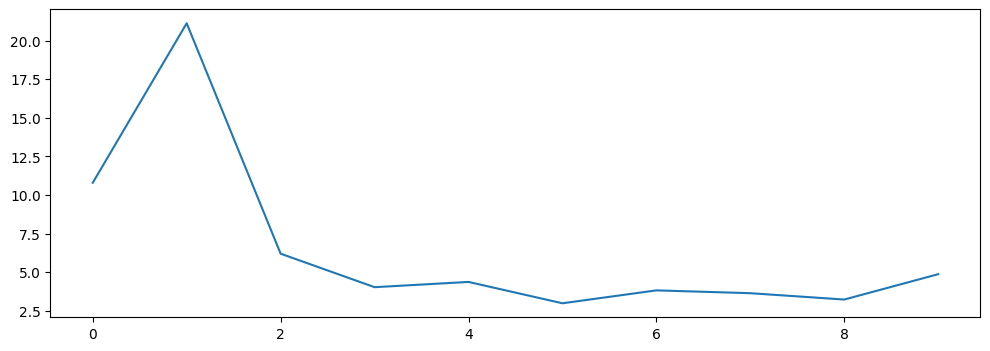

In [ ]:
loss = train_autoencoder(
    model=model,
    dataloader=dataloader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=epochs,
    device=device
)

plt.figure(figsize=(12, 4))
plt.plot(loss)
plt.show()

In [ ]:
def visualize_compare_result(x, recon):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(x, cmap='gray')
    ax[1].imshow(recon, cmap='gray')
    plt.show()

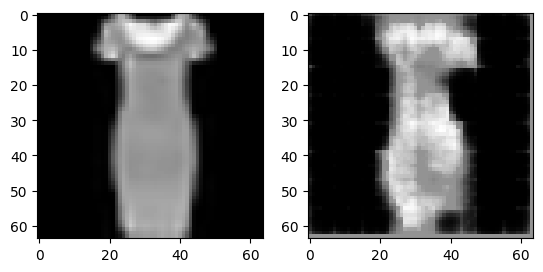

In [ ]:
X, _ = next(iter(dataloader))
with torch.no_grad():
  reconstructed, _, _ = model(X.to(device))
recon = reconstructed[0].permute(1, 2, 0).cpu().detach().numpy()
x = X[0].permute(1, 2, 0).cpu().detach().numpy()
visualize_compare_result(x, recon)